1. Use various clustering methods on the data from the [mall customers datasets](https://www.kaggle.com/datasets/shwetabh123/mall-customers).
Find interesting correlations and try to explain the reasons with appropiate interpretations. Try to find at least some correlations that seem counterintuitive at first. Use dimentionality reduction techniques for better clustering and visualization.
2. Bonus task - Same requirements for the credit card data from the [credit card dataset](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata). This is a harder dataset, so you might need to dig deeper for insights.


In [ ]:
# Download latest version
import kagglehub
path = kagglehub.dataset_download("shwetabh123/mall-customers")
dataset_path = "/".join((path, "Mall_Customers.csv"))

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mall-customers' dataset.
Path to dataset files: /kaggle/input/mall-customers


In [ ]:
import pandas as pd
df = pd.read_csv(dataset_path)

df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


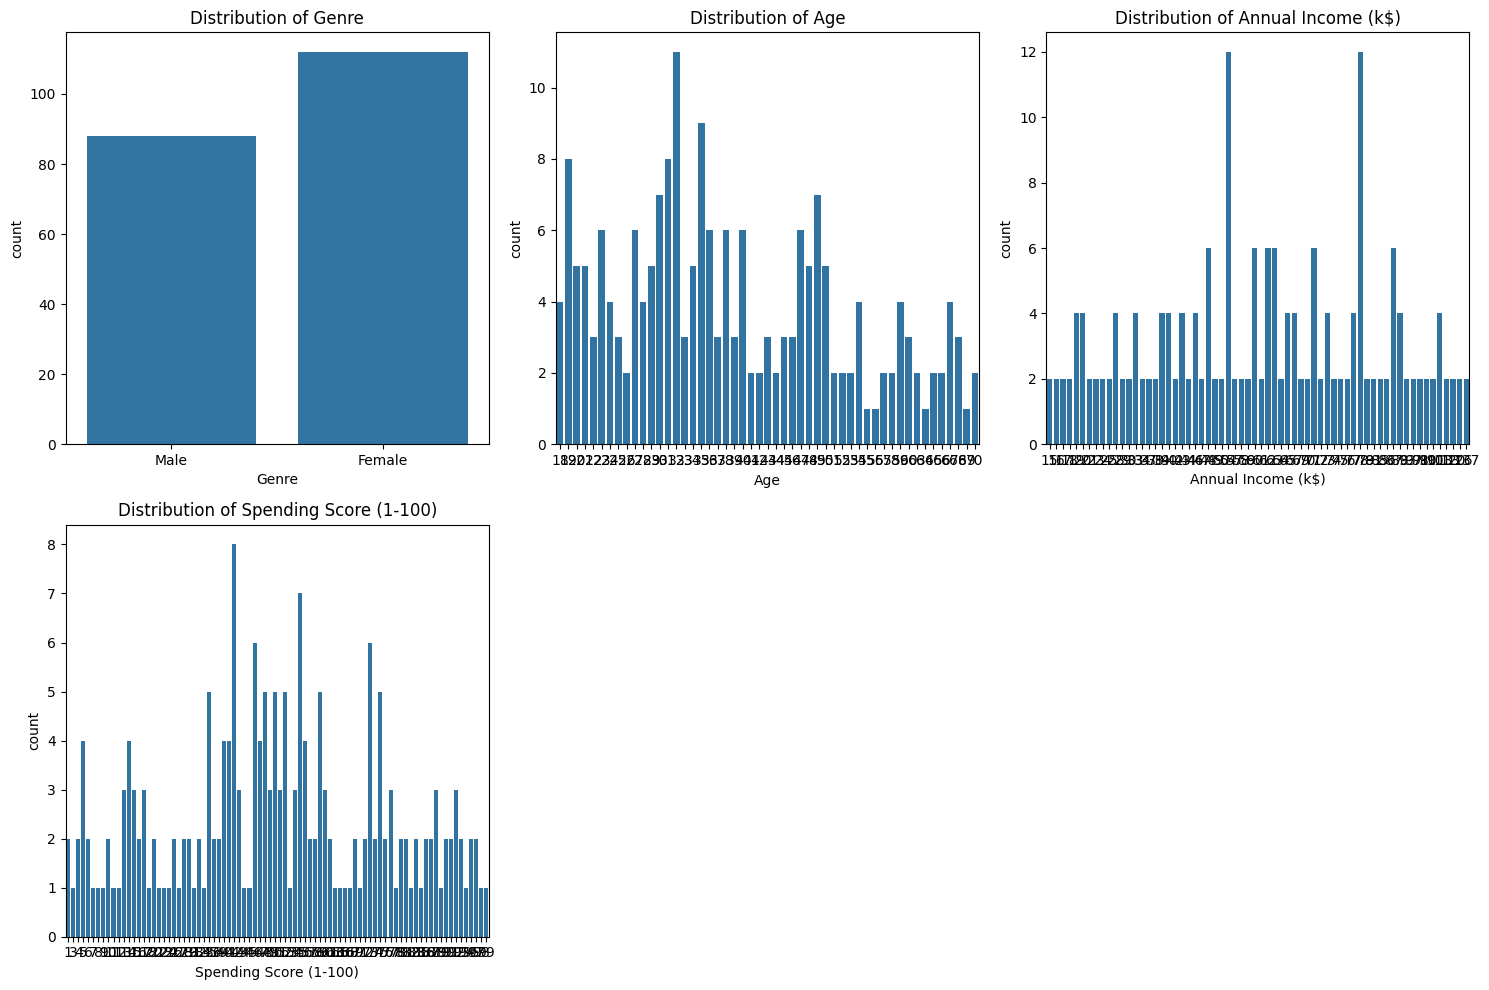

In [ ]:
# Let`s display the distribution of the values for each features
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.columns.tolist()
# Exclude 'dataset' and 'age_range' as they have many unique values or have been visualized differently
cols_to_plot = [col for col in categorical_cols if col not in ['CustomerID']]

# Calculate the number of rows and columns for subplots
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols # Calculate number of rows needed

plt.figure(figsize=(15, n_rows * 5)) # Adjust figure size based on number of rows
for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [ ]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [ ]:
# Display descriptive statistics of the dataset
print(df.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


In [ ]:
# Check for missing values
print(df.isnull().sum())

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


## Preprocessing


Let`s prepare the data for clustering by selecting relevant features, handling categorical features with one-hot encoding, and scaling numerical features using StandardScaler.



In [ ]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
df_clean = df.drop('CustomerID', axis=1)

# Apply one-hot encoding to categorical features
features_encoded = pd.get_dummies(df_clean, columns=["Genre"], drop_first=True)

# Identify numerical columns
numerical_features = features_encoded.select_dtypes(include=['int64', 'float64']).columns

# Initialize and apply StandardScaler to numerical features
scaler = StandardScaler()
features_scaled = features_encoded.copy()
features_scaled[numerical_features] = scaler.fit_transform(features_scaled[numerical_features])

# The resulting DataFrame `features_scaled` is now ready for clustering
display(features_scaled.head())

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
0,-1.424569,-1.738999,-0.434801,True
1,-1.281035,-1.738999,1.195704,True
2,-1.352802,-1.700830,-1.715913,False
3,-1.137502,-1.700830,1.040418,False
4,-0.563369,-1.662660,-0.395980,False


# Dimensionality reduction

We`ll apply PCA and TSNE to reduce the number of features and make clustering and visualization easier.


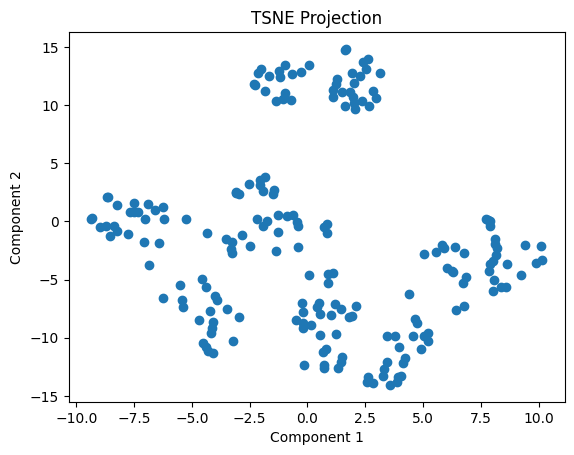

In [ ]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
tsne_proj = tsne.fit_transform(features_scaled)

plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('TSNE Projection')
plt.show()

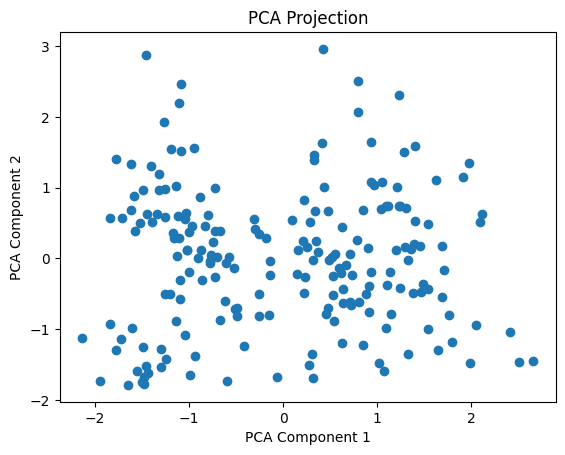

In [ ]:
from sklearn.decomposition import PCA

# Instantiate PCA, keeping 2 components
pca = PCA(n_components=2)

# Fit and transform the scaled features
pca_proj = pca.fit_transform(features_scaled)

plt.scatter(pca_proj[:, 0], pca_proj[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection')
plt.show()

A simple and quick way to interpret the cluster is using radar chart as shown here. The radar chart shows the average value of important features (or columns) for each cluster

-------------
Question 1
------------

Why is there such a difference between PCA and TSNE? Does it mean that one of them is extraordinary and the other one useless? Not quite... but to understand them better we need to look at their differences. Check this out:

https://towardsdatascience.com/pca-vs-tsne-el-cl%C3%A1sico-9948181a5f87

Now state your opinion on why there is such a discrepancy on the given Dataset:

The reason is that PCA is a mathematical approach and tries to separate points as far as possible based on highest variance.
 TSNE is a probabilistic approach and tries to group points as close as possible based on probability that two close points came from the same population distribution.

# Clustering



## KMeans

In [ ]:
from sklearn.cluster import KMeans

# Compute the clusters
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(pca_proj)

In [ ]:
import numpy as np
# Permute the labels
from scipy import stats
labels = np.zeros_like(clusters)
for i in range(5):
    mask = (clusters == i)
    labels[mask] = stats.mode(clusters[mask])[0]

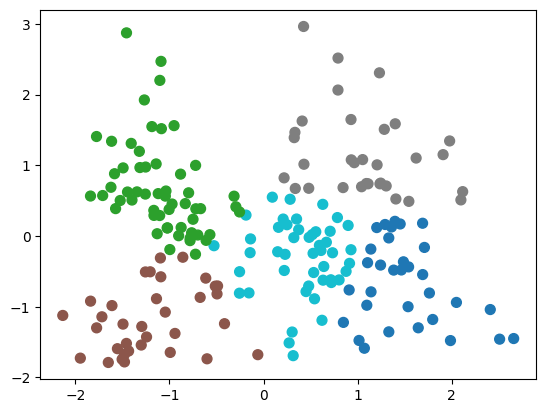

In [ ]:
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=labels, s=50, cmap='tab10')

## Gaussian Mixture Model

In [ ]:
from sklearn import mixture

cv_type = 'full'
n_components = 6
gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
gmm.fit(pca_proj)

GaussianMixture(n_components=6)

In [ ]:
y_mixture = gmm.predict(pca_proj)

In [ ]:
y_mixture

array([2, 2, 5, 2, 5, 2, 5, 2, 1, 2, 1, 2, 1, 2, 5, 2, 5, 2, 5, 2, 5, 2,
       1, 2, 1, 2, 5, 0, 5, 2, 1, 2, 1, 2, 1, 2, 5, 2, 5, 2, 1, 2, 5, 0,
       1, 2, 5, 0, 0, 0, 5, 0, 0, 5, 5, 5, 5, 1, 0, 5, 1, 0, 1, 5, 1, 0,
       5, 1, 0, 0, 3, 5, 1, 1, 1, 0, 5, 5, 0, 5, 1, 5, 3, 5, 0, 5, 5, 0,
       0, 5, 3, 0, 5, 5, 5, 0, 5, 0, 5, 0, 0, 5, 3, 0, 5, 0, 3, 5, 3, 3,
       3, 0, 5, 0, 0, 0, 3, 5, 5, 5, 0, 5, 1, 0, 1, 0, 5, 0, 3, 0, 3, 0,
       1, 0, 5, 0, 3, 0, 5, 0, 3, 0, 1, 0, 5, 0, 3, 0, 5, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 5, 0, 3, 0, 3, 0, 5, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4])

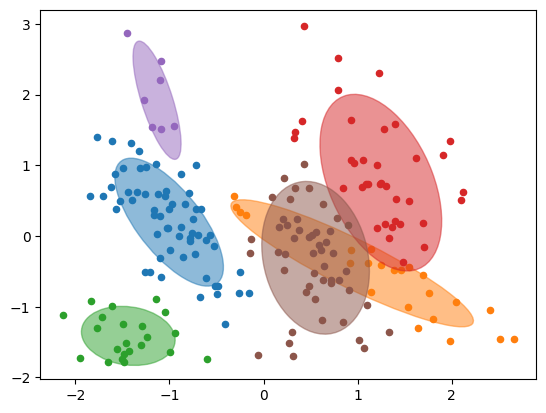

In [ ]:
import matplotlib as mpl
from scipy import linalg
fig = plt.gca()

cmap = mpl.colormaps['tab10']
for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
    v, w = linalg.eigh(cov)
    color = cmap(i / 10)   # evenly spaced colors
    fig.scatter(pca_proj[y_mixture == i, 0], pca_proj[y_mixture == i, 1], s=20, color=color)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180. + angle, color=color)
    ell.set_alpha(.5)
    fig.add_artist(ell)


## DBScan

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1.5, min_samples=10).fit(tsne_proj)
labels = db.labels_

In [ ]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20')

/tmp/ipython-input-2808836070.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab20')


In [ ]:
colors = [0] * labels.size
sizes = [0] * labels.size
for i in range(labels.size):
    if labels[i] == -1:
        colors[i] = 'black'
        sizes[i] = 20
    else:
        colors[i] = cmap(labels[i]/10)
        sizes[i] = 50

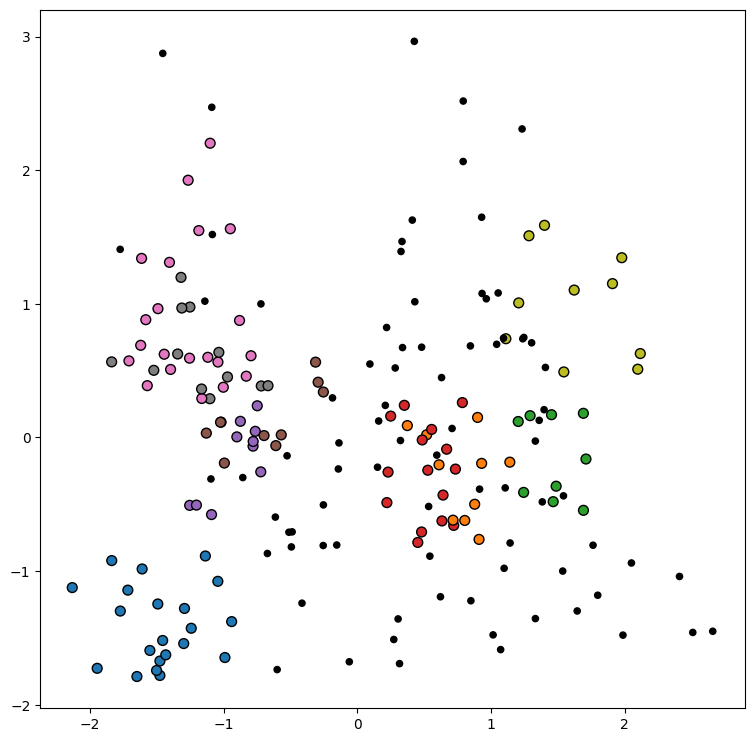

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1, aspect='equal')

plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=colors, s=sizes, edgecolor='k')

## Mean Shift Clustering

/tmp/ipython-input-2435215451.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab20')


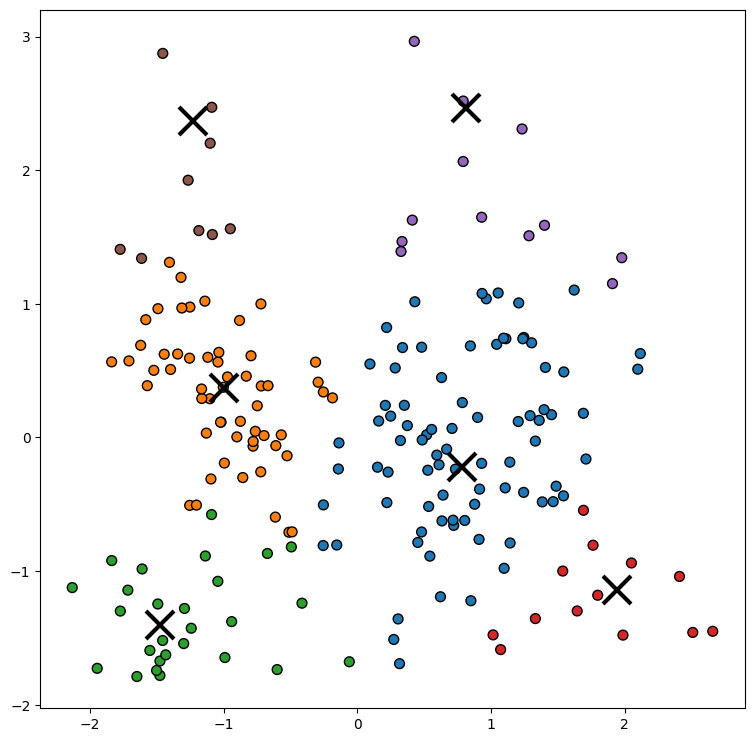

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(pca_proj, quantile=0.12)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pca_proj)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20')

colors = [0] * labels.size
for i in range(labels.size):
    colors[i] = cmap(labels[i]/10)

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=colors, s=50, edgecolor='k')
for cluster_center in cluster_centers:
    plt.plot(cluster_center[0], cluster_center[1], 'x', markeredgecolor='k', markersize=20, mew=3)

/tmp/ipython-input-1600411456.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab20')


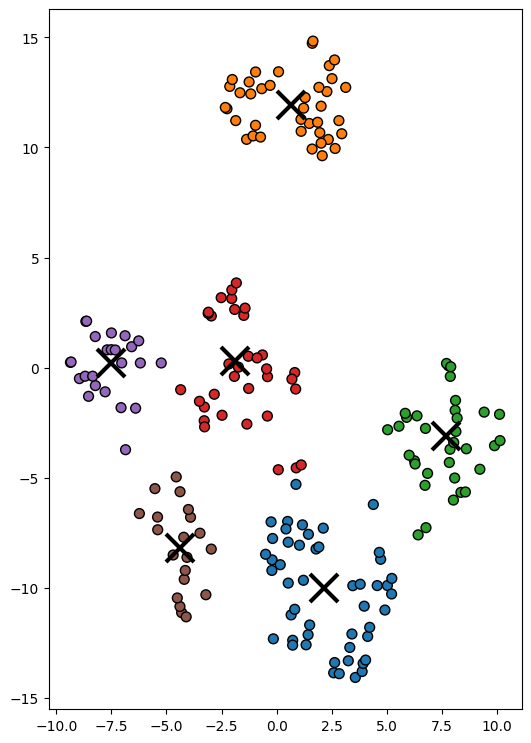

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(tsne_proj, quantile=0.12)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(tsne_proj)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20')

colors = [0] * labels.size
for i in range(labels.size):
    colors[i] = cmap(labels[i]/10)

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=colors, s=50, edgecolor='k')
for cluster_center in cluster_centers:
    plt.plot(cluster_center[0], cluster_center[1], 'x', markeredgecolor='k', markersize=20, mew=3)

It looks like for the MSC model, the TSNE results in a better grouping and visualization of the dataset

## Agglomerative Clustering


/tmp/ipython-input-3024228657.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab20')


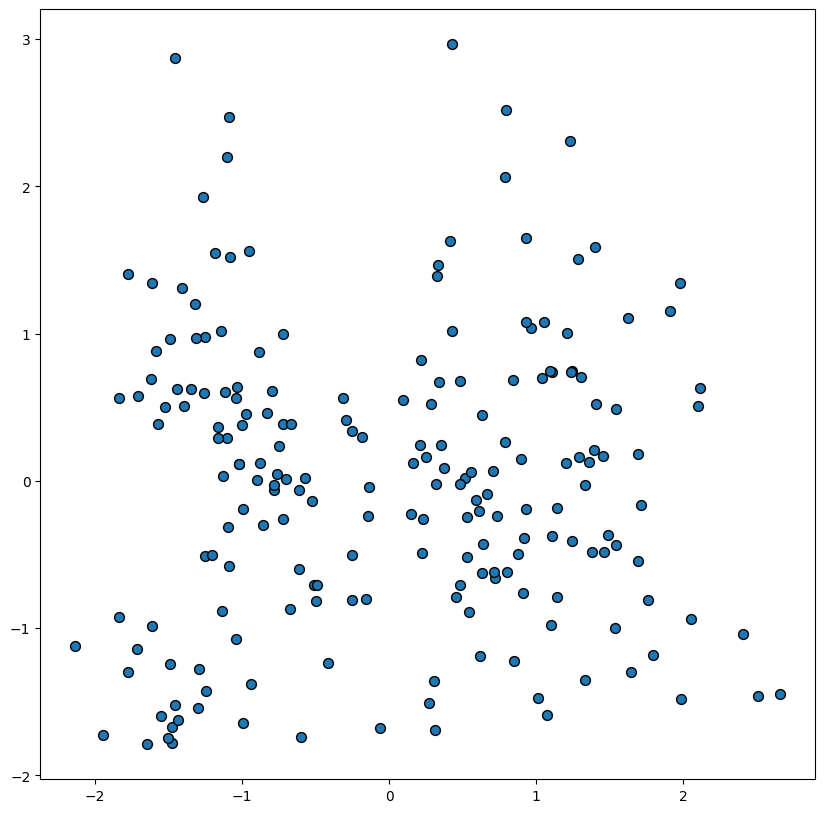

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from sklearn.cluster import AgglomerativeClustering
import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20')

fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor('white')
scat = ax.scatter(pca_proj[:,0], pca_proj[:,1], s=50, edgecolor='k')

In [ ]:
def get_labels(linkage, X, n_clusters, prev_labels=None):
    aggcluster = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)
    aggcluster.fit(X)
    labels = aggcluster.labels_
    new_labels = labels.copy()

    if prev_labels is not None:
        for i in range(10):
            ids = np.arange(len(labels))[labels == i]
            for j in range(10):
                prev_ids = np.arange(len(labels))[prev_labels == j]
                if np.array_equal(ids, prev_ids):
                    new_labels[ids] = j
                elif set(prev_ids).issubset(ids) and prev_ids.size * 2 >= ids.size:
                    new_labels[ids] = j

    return new_labels

In [ ]:
def get_colors(labels):
    colors = [0] * labels.size
    for i in range(labels.size):
        colors[i] = cmap(labels[i]/10)
    return colors

In [ ]:
def animate(i, linkage):
    global labels
    prev_labels = labels
    labels = get_labels(linkage=linkage, X=pca_proj, n_clusters=10-i, prev_labels=prev_labels)
    color = get_colors(labels)
    scat.set_color(color)

In [ ]:
linkage = 'ward'
labels = None
anim = FuncAnimation(fig, animate, fargs=(linkage,), interval=2000, frames=10)
HTML(anim.to_html5_video())

In [ ]:
linkage = 'complete'
labels = None
anim = FuncAnimation(fig, animate, fargs=(linkage,), interval=2000, frames=10)
HTML(anim.to_html5_video())

# Observations



1.   K-Means (on PCA): Found visually distinct, well-separated clusters. Radar charts help understand their characteristics.
Gaussian Mixture Model (on PCA): Identified clusters with varying shapes and densities (shown by ellipses).

2.   Gaussian Mixture Model (GMM): Found clusters with varying shapes and densities.

3.   DBSCAN (on TSNE): Initially found no clusters, treating all points as noise, indicating a need for parameter tuning.

4.   Mean Shift Clustering (MSC): Identified density peaks; visualization on TSNE looked more promising than on PCA.

5.   Agglomerative Clustering (on PCA): Demonstrated hierarchical clustering; different linkages produced different merging patterns.



# Bonus dataset Credit Card

In [2]:
# Download latest version
import kagglehub
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
dataset_path = "/".join((path, "CC GENERAL.csv"))

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ccdata' dataset.
Path to dataset files: /kaggle/input/ccdata


In [3]:
import pandas as pd
df = pd.read_csv(dataset_path)

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


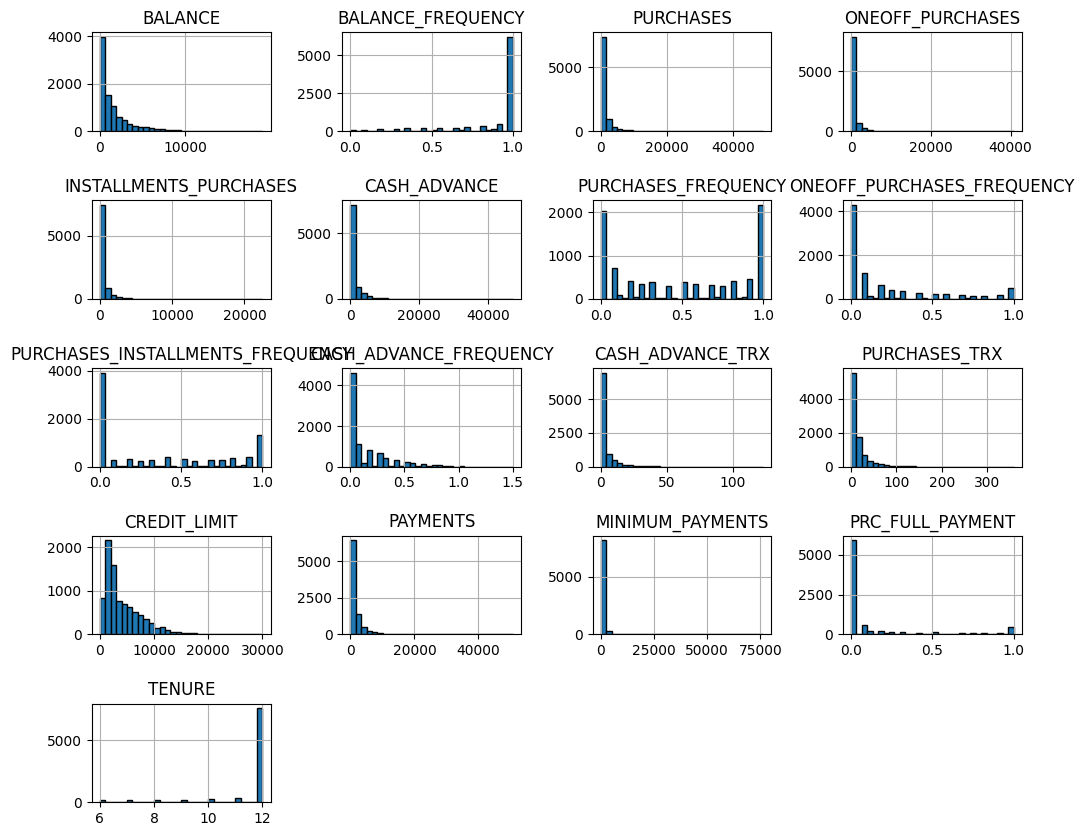

In [4]:
import matplotlib.pyplot as plt

df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

## Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select relevant features for clustering
df_clean = df.drop('CUST_ID', axis=1)

scaler=StandardScaler()
features_scaled_array = scaler.fit_transform(df_clean)

# Convert the scaled NumPy array back to a pandas DataFrame
features_scaled = pd.DataFrame(features_scaled_array, columns=df_clean.columns)

# The resulting DataFrame `features_scaled` is now ready for clustering
display(features_scaled.head())

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960380,-0.528979,-0.305482,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688601,0.818642,0.087735,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826016,-0.383805,-0.099870,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826016,-0.598688,NaN,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905414,-0.364368,-0.261102,-0.525551,0.36068


In [9]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

We`ll handle the missing values by filling them with the mean value of the specific feature

In [11]:
features_scaled = features_scaled.fillna(features_scaled.mean())

## Dimensionality reduction using PCA vs TSNE

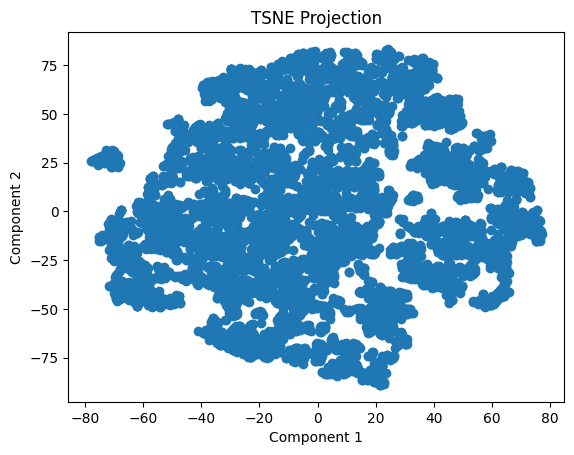

In [12]:
from sklearn.manifold import TSNE
import numpy as np

# Project the data: this step will take several seconds

tsne = TSNE(n_components=2, init='random', random_state=0)
tsne_proj = tsne.fit_transform(features_scaled)

plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('TSNE Projection')
plt.show()

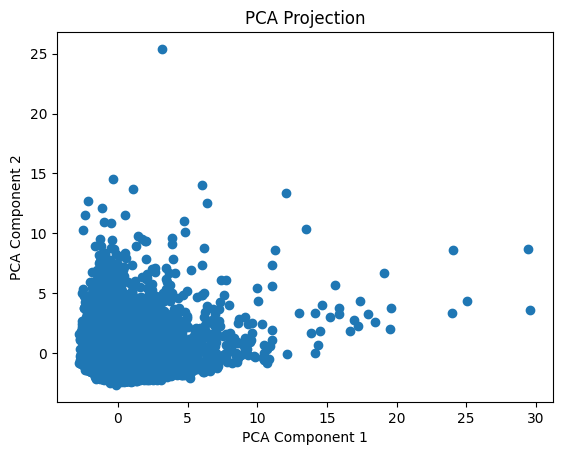

In [13]:
from sklearn.decomposition import PCA

# Instantiate PCA, keeping 2 components
pca = PCA(n_components=2)

# Fit and transform the scaled features
pca_proj = pca.fit_transform(features_scaled)

plt.scatter(pca_proj[:, 0], pca_proj[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection')
plt.show()

We`ll continue using TSNE since the plotting looks like having more separated clusters

## Mean Shift Clustering

/tmp/ipython-input-1600411456.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab20')


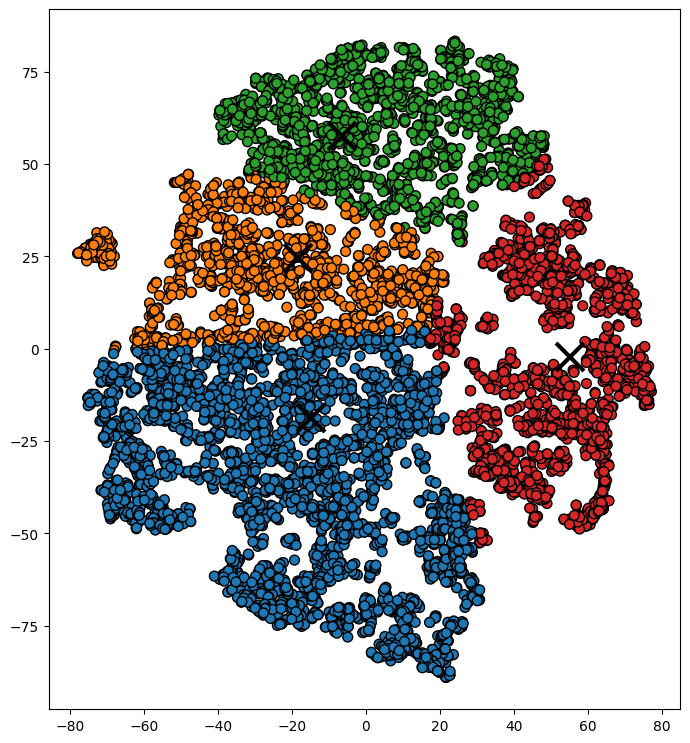

In [14]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(tsne_proj, quantile=0.12)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(tsne_proj)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20')

colors = [0] * labels.size
for i in range(labels.size):
    colors[i] = cmap(labels[i]/10)

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=colors, s=50, edgecolor='k')
for cluster_center in cluster_centers:
    plt.plot(cluster_center[0], cluster_center[1], 'x', markeredgecolor='k', markersize=20, mew=3)

/tmp/ipython-input-2435215451.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab20')


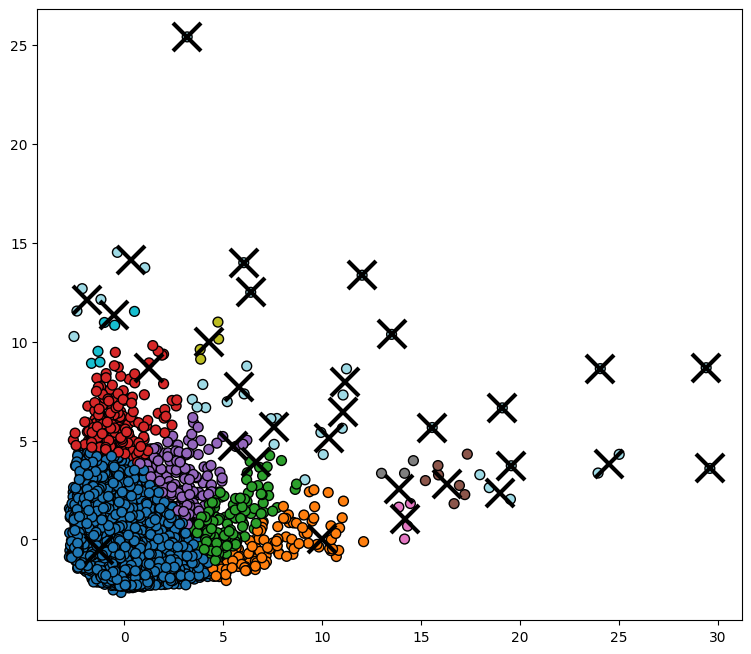

In [15]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(pca_proj, quantile=0.12)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pca_proj)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20')

colors = [0] * labels.size
for i in range(labels.size):
    colors[i] = cmap(labels[i]/10)

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=colors, s=50, edgecolor='k')
for cluster_center in cluster_centers:
    plt.plot(cluster_center[0], cluster_center[1], 'x', markeredgecolor='k', markersize=20, mew=3)